https://arxiv.org/pdf/1611.01599


#Set up Environment

In [6]:
!pip install imageio==2.23.0
!pip install tensorflow==2.10.1
!pip install ultralytics

In [7]:
import os
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
from typing import List
from matplotlib import pyplot as plt
import imageio # Creates gifs to see frames stacked together
from IPython.display import clear_output
CROP_HEIGHT = 46
CROP_WIDTH = 140

In [8]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.32.1
aiohappyeyeballs                 2.3.4
aiohttp                          3.10.1
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.13
albumentations                   1.4.13
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.2
astropy-iers-data                0.2024.8.5.0.32.23
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            24.2.0
audioread               

In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU found")
except:
    print("GPU not found")

GPU not found


# Load and preprocess data

In [10]:
from ultralytics import YOLO
# Load trained model
weights_path = '/content/best.pt'
try:
    object_detect_model = YOLO(weights_path)
    print(f"Loaded model with best weights from {weights_path}")
except FileNotFoundError:
    warnings.warn(f"MODEL NOT FOUND AT {weights_path}, LOADING GENERIC PRETRAINED YOLOv8 MODEL INSTEAD.")
    object_detect_model = YOLO('yolov8n.pt')  # Load a normal YOLO model with pretrained weights

Loaded model with best weights from /content/best.pt


In [11]:
import gdown # Downloads datasets with good compatibility Colab notebooks


url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL' #More managable subset of very large original dataset
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=896833ab-9559-4802-b4ce-876a0b195a56
To: /content/data.zip
100%|██████████| 423M/423M [00:09<00:00, 42.9MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [12]:
def load_video(path: str, detection_model, crop_height: int, crop_width: int) -> List[float]:
    results = detection_model.predict(path, conf=0.5, show=False)
    preprocessed_frames = []

    for result in results:
        if result.boxes.xyxy.shape[0] > 0: # If any detections boxes were detected
            for box in result.boxes.xyxy:
                x1, y1, x2, y2 = box.int() # Get box coordinates as integers
                crop = result.orig_img[y1:y2, x1:x2] # Crop with indices
                grey = tf.image.rgb_to_grayscale(crop)
                resize = tf.image.resize(grey, (crop_height, crop_width))
                preprocessed_frames.append(resize)

    frames_tensor = tf.convert_to_tensor(preprocessed_frames, dtype=tf.float32)
    mean = tf.math.reduce_mean(frames_tensor)
    std = tf.math.reduce_std(frames_tensor)
    normalized_frames = (frames_tensor - mean) / std

    return normalized_frames

In [13]:
# VOCABULARY CONVERSION

vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"Vocab List: {char_to_num.get_vocabulary()}\n"
    f"Vocab size: {char_to_num.vocab_size()}"
    )


Vocab List: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
Vocab size: 40


In [14]:
print(char_to_num(['k', 'e', 'r', 'o']))
print(num_to_char([11, 5, 18, 15]))

tf.Tensor([11  5 18 15], shape=(4,), dtype=int64)
tf.Tensor([b'k' b'e' b'r' b'o'], shape=(4,), dtype=string)


In [15]:
def load_labels(path:str) -> List[str]:
    tokens = []
    with open(path) as f:
        lines = f.readlines()
        for line in lines:
            line = line.split()
            if line[2] != 'sil':
                tokens.append(' ')
                tokens.append(line[2])
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), [-1]))

In [16]:
def load_data(videos_path:str, show_shapes:bool=False): #
    videos_path = bytes.decode(videos_path.numpy())
    # Get the name of the file to be used for alignment path
    file_name = videos_path.split('/')[-1].split('.')[0]
    directory = os.path.dirname(os.path.dirname(videos_path))
    labels_path = f'{directory}/alignments/s1/{file_name}.align'
    frames = load_video(videos_path,
                        detection_model=object_detect_model,
                        crop_height=CROP_HEIGHT,
                        crop_width=CROP_WIDTH,
                       )
    labels = load_labels(labels_path)
    if show_shapes:
        print(f'Frames shape:{frames.shape}\nLabels shape: {labels.shape}')
    return frames, labels

In [17]:
# Paths input as tensors for TF Dataset API compatibility and mapping capabilities
frames, labels = load_data(tf.convert_to_tensor('/content/data/s1/bbaf2n.mpg'))



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/75) /content/data/s1/bbaf2n.mpg: 512x640 1 Mouth, 350.7ms
video 1/1 (frame 2/75) /content/data/s1/bbaf2n.mpg: 512x640 1 Mouth, 381.1ms
video 1/1 (frame 3/75) /content/data/s1/bbaf2n.mpg: 512x640 1 Mouth, 328.8ms
video 1/1 (frame 4/75) /content/data/s1/bbaf2n.mpg: 512x640 1 Mouth, 425.9ms
video 1/1 (frame 5/75) /content/data/s1/bbaf2n.mpg: 512x640 1 Mouth, 472.6ms
video 1/1 (frame 6/75) /content/data/s1/bbaf2n.mpg: 512x640 1 Mouth, 37

In [18]:
def decode_label(labels):
    decoded = [bytes.decode(x) for x in num_to_char(labels).numpy()]
    return tf.strings.reduce_join(decoded)
    #print(tf.strings.reduce_join(decoded).numpy())

Sequence: [39  2  9 14 39  2 12 21  5 39  1 20 39  6 39 20 23 15 39 14 15 23]
Label: b' bin blue at f two now'


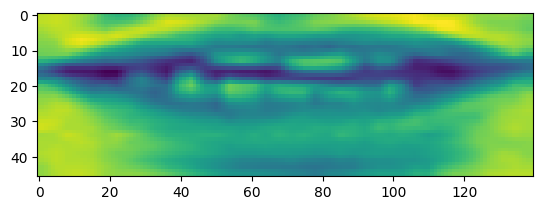

In [19]:
plt.imshow(frames[np.random.randint(0, frames.shape[0])])
print(f"Sequence: {labels}\nLabel: {decode_label(labels)}")

In [20]:
def map_func(path:str)->List[str]:
    return tf.py_function(load_data, [path], (tf.float32, tf.int64))

# Data Pipeline

In [21]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(map_func)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/75) /content/data/s1/pbao9s.mpg: 512x640 1 Mouth, 644.5ms
video 1/1 (frame 2/75) /content/data/s1/pbao9s.mpg: 512x640 1 Mouth, 461.8ms
video 1/1 (frame 3/75) /content/data/s1/pbao9s.mpg: 512x640 1 Mouth, 297.0ms
video 1/1 (frame 4/75) /content/data/s1/pbao9s.mpg: 512x640 1 Mouth, 372.4ms
video 1/1 (frame 5/75) /content/data/s1/pbao9s.mpg: 512x640 1 Mouth, 181.6ms
video 1/1 (frame 6/75) /content/data/s1/pbao9s.mpg: 512x640 1 Mouth, 20

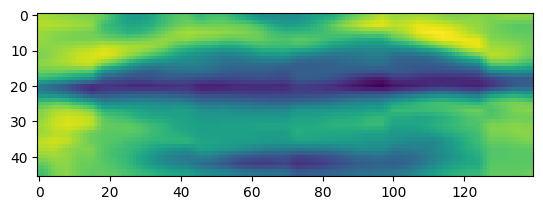

In [26]:
frames, labels = data.as_numpy_iterator().next()
plt.imshow(frames[0][0])
print(f"Sequence: {labels[0]} \n Label: {decode_label(labels[0])}")

In [27]:
test = data.as_numpy_iterator()
val = test.next()
val[0][0]



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/75) /content/data/s1/bbbf6n.mpg: 512x640 1 Mouth, 336.9ms
video 1/1 (frame 2/75) /content/data/s1/bbbf6n.mpg: 512x640 1 Mouth, 347.2ms
video 1/1 (frame 3/75) /content/data/s1/bbbf6n.mpg: 512x640 1 Mouth, 303.3ms
video 1/1 (frame 4/75) /content/data/s1/bbbf6n.mpg: 512x640 1 Mouth, 211.4ms
video 1/1 (frame 5/75) /content/data/s1/bbbf6n.mpg: 512x640 1 Mouth, 194.6ms
video 1/1 (frame 6/75) /content/data/s1/bbbf6n.mpg: 512x640 1 Mouth, 20

array([[[[     1.0708],
         [     1.0708],
         [     1.1186],
         ...,
         [    0.84362],
         [    0.83166],
         [    0.83166]],

        [[     1.0651],
         [     1.0651],
         [     1.1129],
         ...,
         [    0.83504],
         [    0.82594],
         [    0.82594]],

        [[     1.0453],
         [     1.0453],
         [     1.0932],
         ...,
         [    0.80541],
         [    0.80619],
         [    0.80619]],

        ...,

        [[     1.0677],
         [     1.0677],
         [     1.0868],
         ...,
         [    0.86987],
         [    0.83478],
         [    0.83478]],

        [[     1.1072],
         [     1.1072],
         [     1.1115],
         ...,
         [    0.84024],
         [    0.79527],
         [    0.79527]],

        [[     1.1186],
         [     1.1186],
         [     1.1186],
         ...,
         [    0.83166],
         [    0.78383],
         [    0.78383]]],


       [[[     1.1665],



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



In [28]:
imageio.mimsave('./example.gif', val[0][0], fps=10)

video 1/1 (frame 1/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 964.3ms


video 1/1 (frame 2/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 980.9ms


#Make NN

In [29]:
vid_shape = data.as_numpy_iterator().next()[0][0].shape


video 1/1 (frame 3/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 495.3ms
video 1/1 (frame 4/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 231.5ms
video 1/1 (frame 5/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 260.8ms
video 1/1 (frame 6/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 332.6ms
video 1/1 (frame 7/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 436.2ms
video 1/1 (frame 8/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 348.0ms
video 1/1 (frame 9/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 296.1ms
video 1/1 (frame 10/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 322.8ms
video 1/1 (frame 11/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 312.3ms
video 1/1 (frame 12/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 302.3ms
video 1/1 (frame 13/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 341.5ms
video 1/1 (frame 14/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 293.0ms
video 1/1 (frame 15/75) /content/data/s1/bras8p.mpg: 512x640 1 Mouth, 

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, TimeDistributed, Flatten, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

lipnet_model = Sequential([
    Conv3D(128, 3, input_shape=vid_shape, padding='same', activation='relu'),
    MaxPooling3D((1,2,2)),
    Dropout(0.5),
    Conv3D(256, 3, padding='same', activation='relu'),
    MaxPooling3D((1,2,2)),
    Dropout(0.5),
    Conv3D(75, 3, padding='same', activation='relu'),
    MaxPooling3D((1,2,2)),
    Dropout(0.5),

    TimeDistributed(Flatten()),

    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
    Dropout(0.5),

    Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax')
])


In [31]:
lipnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 75, 23, 70, 128)   0         
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 75, 11, 35, 256)  

In [32]:
yhat = lipnet_model.predict(val[0])
print(f"Coded:\n{np.argmax(yhat[0], axis=1)}\n")
print(f"Decoded:\n{decode_label(np.argmax(yhat[0], axis=1))}")

1/1 [==============================] - 17s 17s/step
Coded:
[20 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 40 40]

Decoded:
b'tt'


# Train Model

In [33]:
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [34]:
lipnet_model.compile(loss=ctc_loss, optimizer=Adam(learning_rate=0.001))

In [35]:
# Load Pretrained Lipnet Weights
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')
lipnet_model.load_weights('models/checkpoint')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=07455692-9082-4c31-bf20-f6a3efee98ff
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 73.6MB/s]


In [ ]:
#Train Model (Not required since pretrained weights are loaded)
#lipnet_model.fit(train, validation_data=test, epochs=50)

# Test Model

In [36]:
def batch_video(videos_path:str):
    video_tensor = load_video(videos_path,
                              detection_model=object_detect_model,
                              crop_height=CROP_HEIGHT,
                              crop_width=CROP_WIDTH,
                              )

    num_frames = video_tensor.shape[0]
    batch_size = 75

    # Number of complete batches based on batch size
    num_batches = num_frames // batch_size

    # Trim video from remainder frames to have a whole number of batches
    trimmed_frames = num_batches * batch_size
    trimmed_video_tensor = video_tensor[:trimmed_frames]

    # Form batches based on batch size and determined number of batches
    batches = tf.reshape(trimmed_video_tensor, (num_batches, batch_size, CROP_HEIGHT, CROP_WIDTH, 1))

    # Pad remainder frames that were trimmed
    remainder_frames = num_frames % batch_size
    if remainder_frames > 0:
        remainder_video_tensor = video_tensor[-remainder_frames:]
        padding_frames = batch_size - remainder_frames
        padding_tensor = tf.zeros((padding_frames, CROP_HEIGHT, CROP_WIDTH, 1), dtype=video_tensor.dtype)
        padded_remainder_video_tensor = tf.concat([remainder_video_tensor, padding_tensor], axis=0)

        # Add the padded batch to the rest of the batches
        batches = tf.concat([batches, tf.expand_dims(padded_remainder_video_tensor, axis=0)], axis=0)
        imageio.mimsave('./test.gif', batches[0], fps=10)

    return batches

In [58]:
def predict_and_compare(path:str, real_label:bool=True):

    if real_label:
        sample = load_data(tf.convert_to_tensor(path))
        yhat = [lipnet_model.predict(tf.expand_dims(sample[0], axis=0))]
    else:
        batches = batch_video(path)
        yhat = []
        for i in range(0,batches.shape[0]-1):
            print(f"Predicting for batch {i+1} of {batches.shape[0]}...")
            yhat.append(lipnet_model.predict(tf.expand_dims(batches[i], axis=0)))


    # Decode predictions
    clear_output()
    predictions_str = ""

    for prediction in yhat:
        decoded = tf.keras.backend.ctc_decode(prediction, input_length=[75], greedy=True)[0][0].numpy()
        predictions_str += decode_label(decoded[0]).numpy().decode('utf-8') + " "

    print(f"PREDICTIONS:\n {predictions_str.strip()}\n")
    if real_label:
        print(f"ACTUAL TEXT:\n {decode_label(sample[1]).numpy().decode('utf-8').strip()}")

In [59]:
# Repredicting for train data sample:
predict_and_compare('/content/data/s1/bbaz6p.mpg', real_label=True)

PREDICTIONS:
 s ee s ix pleasin

ACTUAL TEXT:
 bin blue at z six please


In [47]:
# Predicting for unseen test data:
predict_and_compare('/content/test_video.mp4', real_label=False)
actual_text = """Uh we didn't meet um until this morning. Um but I watched the France game when
I got home. Um I didn't I didn't watch uh our whole game I watched the France game first."""
print(f"ACTUAL TEXT:\n {actual_text}")

PREDICTIONS:
 s bue i oe slgain s een it t oue again  een in i sive sgain s bree ni so pslgain

ACTUAL TEXT:
 Uh we didn't meet um until this morning. Um but I watched the France game when 
I got home. Um I didn't I didn't watch uh our whole game I watched the France game first.
